In [4]:
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

#Settings for Pandas
pd.options.display.max_rows=10
pd.options.display.float_format = "{:.1f}".format

In [5]:
print(tf.__version__)

2.3.1


In [25]:
#Import Dataset
training_df = pd.read_csv('./dataset/housing.csv')
#Scale the label
training_df["median_house_value"] /= 1000.0
training_df["ocean_proximity"] = training_df["ocean_proximity"].astype("category")
training_df["ocean_proximity"] = training_df["ocean_proximity"].cat.codes
print(training_df["total_bedrooms"].isnull().sum())
training_df = training_df.dropna()
training_df.head()

207


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.2,37.9,41.0,880.0,129.0,322.0,126.0,8.3,452.6,3
1,-122.2,37.9,21.0,7099.0,1106.0,2401.0,1138.0,8.3,358.5,3
2,-122.2,37.9,52.0,1467.0,190.0,496.0,177.0,7.3,352.1,3
3,-122.2,37.9,52.0,1274.0,235.0,558.0,219.0,5.6,341.3,3
4,-122.2,37.9,52.0,1627.0,280.0,565.0,259.0,3.8,342.2,3


In [26]:
#Describe the dataframe
training_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20433.0,20433.0,20433.0,20433.0,20433.0,20433.0,20433.0,20433.0,20433.0,20433.0
mean,-119.6,35.6,28.6,2636.5,537.9,1424.9,499.4,3.9,206.9,1.2
std,2.0,2.1,12.6,2185.3,421.4,1133.2,382.3,1.9,115.4,1.4
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0,0.0
25%,-121.8,33.9,18.0,1450.0,296.0,787.0,280.0,2.6,119.5,0.0
50%,-118.5,34.3,29.0,2127.0,435.0,1166.0,409.0,3.5,179.7,1.0
75%,-118.0,37.7,37.0,3143.0,647.0,1722.0,604.0,4.7,264.7,1.0
max,-114.3,42.0,52.0,39320.0,6445.0,35682.0,6082.0,15.0,500.0,4.0


In [27]:
#Functions for building the model
def build_model(learning_rate):
    #Call on Keras's sequential model
    model = tf.keras.models.Sequential()
    
    #Topography of model. Single node on
    #Single node, single layer
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))
    
    #Compile the model into code that tensorflow can execute.
    #Configure training to minimize models mean squared error
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),loss="mean_squared_error",
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [28]:
#Functions for training the model
def train_model(model,df,features,label,epochs,batch_size):
    history = model.fit(x=df[features],y=df[label],batch_size=batch_size,epochs=epochs)
    
    #Gather the trained weights and bias
    trained_weight = model.get_weights()[0]
    trained_bias = model.get_weights()[1]
    
    #The epochs are stored separately from rest of the history
    epochs = history.epoch
    
    #Isolate error for each epoch
    hist = pd.DataFrame(history.history)
    
    #To track progression of the training, we will take snapshot
    #of model's root mean squared error at each epoch
    rmse = hist["root_mean_squared_error"]
    
    return trained_weight,trained_bias,epochs,rmse

In [29]:
#Plotting functions
def plot_the_model(trained_weight,trained_bias,features,label):
    plt.xlabel(features)
    plt.ylabel(label)
    
    #Scatter plot for 200 random points
    random_examples = training_df.sample(n=200)
    plt.scatter(random_examples[features],random_examples[label])
    
    #Draw the model line from x0,y0 to x1,y1
    x0 = 0
    y0 = trained_bias
    x1 = 10000
    y1 = trained_bias + (trained_weight*x1)
    plt.plot([x0,x1],[y0,y1],c='r')
    
    plt.show()

def plot_the_loss_curve(epochs,rmse):
    #Plot loss vs epochs
    plt.figure()
    plt.xlabel("Epochs")
    plt.ylabel("Root mean squared error")
    
    plt.plot(epochs,rmse, label="Loss")
    plt.legend()
    plt.ylim([rmse.min()*0.97,rmse.max()])
    plt.show()

Epoch 1/30
682/682 [==============================] - 1s 806us/step - loss: 48138.8555 - root_mean_squared_error: 219.4057
Epoch 2/30
682/682 [==============================] - 0s 702us/step - loss: 27711.3633 - root_mean_squared_error: 166.4673
Epoch 3/30
682/682 [==============================] - 0s 675us/step - loss: 26417.0625 - root_mean_squared_error: 162.5333
Epoch 4/30
682/682 [==============================] - 1s 741us/step - loss: 25633.0684 - root_mean_squared_error: 160.1033
Epoch 5/30
682/682 [==============================] - 1s 804us/step - loss: 24849.9863 - root_mean_squared_error: 157.6388
Epoch 6/30
682/682 [==============================] - 1s 794us/step - loss: 23992.6172 - root_mean_squared_error: 154.8955
Epoch 7/30
682/682 [==============================] - 0s 728us/step - loss: 23319.0371 - root_mean_squared_error: 152.7057
Epoch 8/30
682/682 [==============================] - 0s 688us/step - loss: 22841.4219 - root_mean_squared_error: 151.1338
Epoch 9/30
682/6

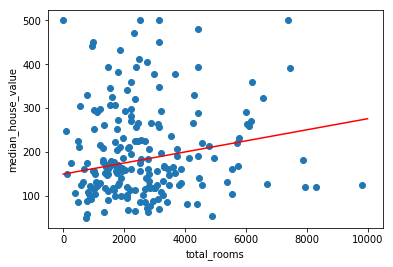

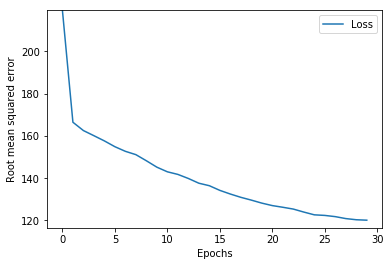

In [30]:
#Calling the model
#Define hyperparameters
learning_rate = 0.01
epochs = 30
batch_size = 30

#Feature and Label
my_feature = "total_rooms"
my_label = "median_house_value"

#Discard pre-existing values of model
my_model = None
my_model = build_model(learning_rate)
weight,bias,epochs,rmse = train_model(my_model,training_df,my_feature,my_label,epochs,batch_size)

print("Learned weight of model = ",weight)
print("Learned bias of model = ",bias)

plot_the_model(weight,bias,my_feature,my_label)
plot_the_loss_curve(epochs,rmse)

In [ ]:
def predict_house_value(n,feature,label):
    "Predict house value based on a feature"
    
    batch = training_df[feature][10000:10000+n]
    predicted_values = my_model.predict_on_batch(x=batch)